# Rough Prototype Tight-Binding Hamiltonian Model Builder
S. Torrisi, E. Muramoto, T. Zhou, S. Fang


### First: import the right libraries, and specify lists/dictionaries/helper functions that are going to be useful to the later operation of the program.

# Import Libraries;  Define Helper Functions

In [77]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import scipy.interpolate as interp

#################################
## ORBITAL LOOKUP AND REFERENCE #
#################################

# Orbitals in the order of wannier90 output.

bilayer_orbitals = [
          "d1b","d2b", "d3b", "d4b", "d5b", # Bottom transition metal D orbitals
          "d1t","d2t","d3t","d4t","d5t",    # Top transition metal D orbitals
          "pzbi","pybi","pxbi",           # Bottom Inner chalcogen P Orbitals
          "pzbo","pybo","pxbo",             # Bottom Outer chalcogen P Orbitals
          "pzto","pyto","pxto",             # Top outer Chalcogen P orbitals
          "pzti","pyti","pxti"              # Top inner Chalcogen P orbitals
]

# Orb_to_index accepts the name of an orbital and returns an index.
# index_to_orb does the opposite.
orb_to_index = {}
index_to_orb = {}

for n in range(22):
    orb_to_index[bilayer_orbitals[n]] = n
    index_to_orb[n] = bilayer_orbitals[n]

    
def reduce_index(n):
    """
    Maps an input d-orbital to a value from 0-4,
    Maps an input p-orbital to the b
    
    The desired enumeration is:
    [0,1,2,3,4]: D-Orbitals
    [5,6,7]: Upper P-orbital
    [8,9,10]: Lower P-orbital
    """
    
    if n in [0,1,2,3,4]: # D ORBITALS IN THE BOTTOM LAYER
        return n
    
    if n in [5,6,7,8,9]: # D ORBITALS IN THE TOP LAYER
        return n-5
    
    if n in [10,11,12]: # TOP P ORBITAL FOR BOTTOM LAYER
        return n-5
    
    if n in [13,14,15]: # BOTTOM P ORBITAL FOR BOTTOM LAYER
        return n-5
    
    if n in [16,17,18]: # TOP P ORBITAL IN THE TOP LAYER
        return n-11
        
    if n in [19,20,21]: # BOTTOM P ORBITAL IN THE BOTTOM LAYER
        return n-11
    

    print("Warning!! Passed an index that is not in [0,21], not acceptable bounds!")

# Functions for creating and manipulating atom objects

In [78]:

class atom(object):
    """
    Contains three attributes:
    
    int layer : 0 or 1 depending on lower/upper
    tuple index (int,int) which specifies where it is on it's original undistorted bravais lattice
    tuple position (float,float) or (float,float,float) depending on if we have xy or xyz 
    """
    def __init__(self,layer=0,index=(0,0),position=(0,0)):
        self.layer=layer # takes form 0,1
        self.index=index # takes form (n,m) or 'None'
        self.position= position #takes form (x,y) or #(x,y,z)
        

def sort_atoms_by_layer(atoms):
    
    bots=[atom for atom in atoms if atom.layer==0]
    tops=[atom for atom in atoms if atom.layer==1]
    
    return bots+tops

def generate_atom_positions(A,R,Nmin,Nmax,Mmin,Mmax,z=3.5):
    """
    Generates a simple rotation with no relaxation and a constant z coordinate
    
    np array A : Matrix of 2D bravais lattice which goes [[a11, a21],[a12,a22]] acting on [n,m]
    np array R : Matrix which rotates the lattice
    int N:       Extent of one direction of the lattice
    int M:       Extent of another direction of the lattice
    """
    indices=[]
    positions=[]
    
    atoms=[]
    # Set up (n,m) integer tuples which index the atoms in each lattice
    for n in range(Nmin,Nmax):
        for m in range(Mmin,Mmax):
            indices.append((n,m))
            
    # Obtain positions by multiplying the indices by the Bravais matrix A
    for x in indices:
        # Generate bottom layer 'atom'
        newpos=np.append(np.dot(A,np.array(x)),(0))
        atoms.append(atom(layer=0,index=x,position=newpos))
        # Generate top layer 'atom'
        newpos=np.append(np.dot(np.dot(R,A),np.array(x)),z)
        atoms.append(atom(layer=1,index=x,position=newpos))
        
    
    # List of objects of type atom
    return atoms
        
    
def plot_atom_positions(atoms):

    bot_atoms=[at for at in atoms if at.layer==0]
    top_atoms=[at for at in atoms if at.layer==1]
    
    plt.figure()
    plt.scatter([at.position[0] for at in bot_atoms], [at.position[1] for at in bot_atoms],color='b',label='Bottom')
    plt.scatter([at.position[0] for at in top_atoms], [at.position[1] for at in top_atoms],color='r',label='Top')
    plt.legend()
    plt.show()
    
def print_atom_positions(atoms,filename):
    
    with open(filename,'w') as f:
        for at in atoms:
            at_str=str(at.position[0])+','+str(at.position[1])+',' + str(at.position[2])+'\n'
            f.write(at_str)
    


[ 8.58324192  9.18674222]
[ 0.58324192  0.18674222]
(2.2098608015922947, -0.65699999999999759)


## Optional: Reads printed atomic positions

In [ ]:
def read_positions(file):
    
    ## Assumes data which is formatted as 
    #  x,y,layer   | with type | float, float, 0 or 1
    # or 
    # x,y,z, layer | with type | float, float, float, 0 or 1
    #  for when we implement z-relaxation.
    
    
    with open(file,'r') as f:
        thelines=f.readlines()
        
    ####################
    # This chunk of code checks to see if there is a alphabet letter in the first line
    # which is a reasonable expectation for the header. If there is a header, it starts on the second line.
    ####################
    alphabet="abcdefhijklmnopqrstuvwxyz"
    alphabet=[alphabet[i] for i in range(26)]
    start_idex=0
    for letter in alphabet:
        if letter in thelines[0].lower():
            start_index=1
    
    ####################
    # Turn the lines into atoms
    ####################    
    
    atoms=[None]*len(thelines[start_index:])
    for n in range(len(thelines[start_index:])):
        [xpos, ypos, layer] = thelines.split(',')
        atoms[n] = atom(layer=int(layer), position=(float(xpos),float(ypos)))


    return atoms
    

# Optional: Unit Cell Modulus Helper Function

In [ ]:

def unit_cell_modulus(A,Dx,Dy,Ainv=None):
    """ 
        
        Assumes A has the form
        
        [a1x, a2x] [n] = [x]
        [a1y, a2y] [m] = [y]
        
        so takes the transpose to make it
        
        [A1x, A1y]
        [A2x, A2y]
                
        Takes an x,y position and modulates it into the unit cell.
        
        Works by solving the system of equations
        x = c * a1_x  + d a2_x
        y = c * a1_y  + d a2_y 
        
        Then taking the coefficients c and d modulo 1, which places them into the unit cell.
        
        If this will be called many times, pass the inverted matrix A in as Ainv.

    
    """
    if Ainv is None:
        Ainv = la.inv(A.T)
    indexes=np.dot(Ainv,np.array([Dx,Dy]))   # Obtain c and d   
    print(indexes)
    indexes=np.array([x%1 for x in indexes]) # Modulate by 1
    print(indexes)

    unit_cell_pos= np.dot(A.T,indexes)         # Put back into real space
    return unit_cell_pos[0],unit_cell_pos[1]

print(unit_cell_modulus(A,51,1))

## Code which concerns querying the spark database; much of which is to be filled in by the intelligent and talented Eri and Tianning

In [80]:
def query_tbh_data(Dx, Dy, orb_from, orb_to, Dz=0):
    
    ###############
    # This is one option where we would query the database for one Dx,Dy,Dy. orb_from, orb_to, 
    # the difference in position between the two orbitals as well as the layer of each atom.
    # In interest of sooner implementation, we should do this a different way.
    ###############
    
    
    
    
    pass

def load_all_orbital_couplings(orb_from,orb_to,imag=False):


    
    ###############
    # This is where we would query the database for the all-orbitals-at once.
    # The arguments being the orbital from and to; the returned value being a set of
    # displacements, and real and imaginary component that are associated with a given orbital.
    # We could have the presence of the imaginary value be optional. 
    ###############
    
    # This should have an array of the form: [x,y,z,real,imag]*n or, shape=[5,NN]
    
    pass
    
    #if not imag: return array of  [Dx,Dy,Dz,real,imag]* data count
    # if imag: return array of [Dx, Dy Dz. real]

    
    
    

Processing coupling between orbital 0 and 0


TypeError: 'NoneType' object is not iterable

# Build Model TBH

In [ ]:

def build_model_draft_1(atoms):
    """ 
        variable : datatype, description 
        ---
        atoms: list, of objects of type atom
        
        Structure matrix so upper-left quadrant is bottom layer, lower-right is top layer
        Convention is 1,2,3,4,5: D
                      6,7,8: p_bottom
                      9,10,11: p_top
                      
    """
    NN = len(atoms) # Get length of input set of atoms
    
    TBH = np.empty(shape=(NN*11,NN*11)) # Pre-allocate orbital-orbital coupling matrix    
    displacements=[ [ [0]*3]*NN]*NN  # shape=(NN,NN,3) corresponding to (atom_from, atom_to,[x,y,z] )
    flatdisps=[] #Array of length NN*NN containing the displacements between every pair of atoms
    
    # Loop over all atoms, computing each individual displacement
    for i in range(NN):
        for j in range(NN):
            flatdisps.append([atoms[j].position[n] - atoms[i].position[n] for n in range(3)])
            for n in range(3):
                displacements[i][j][n]= atoms[j].position[n]- atoms[i].position[n]

    flatdisps=[x for x in displacements]
    

    pass
    for k in range(11):
        for l in range(11):
            from_orb = index_to_orb_short[k]
            to_orb   = index_to_orb_short[l]
            
            couplings = load_all_orbital_couplings(from_orb,to_orb)
            
            # Coupling has shape [[x,y,z],[real,imag],n]
            data_disps = [[coup[i] for i in range(3)] for coup in couplings]
            
            real_vals = [coup[4] for coup in couplings]
            
            
            
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
            couplings= interp.griddata(points=data_disps,values=real_vals,xi=flatdisps)
            
            for i in range(NN):
                for j in range(NN):
                    TBH[i*11+k,j*11+l]=couplings[i*11+j*11]
            
                  
def build_model_draft_2(atoms):
    """ 
        atoms: list, of objects of type 'atom'
                      
    """
    
    ########################
    #1.      SETUP         #
    ########################
    atoms=sort_atoms_by_layer(atoms)
    Nbot=len([atom for atom in atoms if atom.layer==0])
    Ntop=len([atom for atom in atoms if atom.layer==1])
    
    
    NN = len(atoms) # Get length of input set of atoms
    
    TBH = np.empty(shape=(NN*11,NN*11)) # Pre-allocate orbital-orbital coupling matrix    
    
    
    
    ########################
    #2.   DISPLACEMENTS    #
    ########################
    
    # Calculate all displacements
    displacements=[ [ [0]*3]*NN]*NN  # shape=(NN,NN,3) corresponding to (atom_from, atom_to,[x,y,z] )
    flatdisps=[]

    # Loop over all atoms, computing each individual displacement
    for i in range(NN):
        for j in range(NN):
            flatdisps.append([atoms[j].position[n]-atoms[i].position[n] for n in range(3)])
            #Only compute displacements for the interlayer ones
            #if atoms[j].layer!=atoms[i].layer:
            for n in range(3):
                displacements[i][j][n]= atoms[j].position[n]- atoms[i].position[n]

    atom_disps= np.empty(shape=(NN,3))

    for i in range(NN):
        for j in range(3):
            atom_disps[i,j]=float(flatdisps[i][j])

    
    ########################
    #3. GENERATE THE MATRIX#
    ########################

    # Loop over orbitals
    
    for k in range(0,22):
        for l in range(0,22):
    # These versions of the loop only go between interlayer coupling
    #for k in [0,1,2,3,4,10,11,12,13,14,15]:
    #    for l [5,6,7,8,9,16,17,18,19,20,21]:
            print("Processing coupling between orbital %d and %d" %(k,l))
            
            couplings = load_all_orbital_couplings(k,l)
            
            # Coupling has shape [[x,y,z],[real,imag],n]
            
            data_disps = [[coup[i] for i in range(3)] for coup in couplings]
            real_vals = [coup[4] for coup in couplings]
        
            # https://docs.scipy.org/doc/scipy/reference/generated/scipy.interpolate.griddata.html#scipy.interpolate.griddata
            couplings= interp.griddata(points=data_disps,values=real_vals,xi=atom_disps,fill_value=0)
            
            for i in range(NN):
                for j in range(NN):
                
                    TBH[i*11+reduce_index(k),j*11+reduce_index(l)] = couplings[i*11+j*11]
                    
                    
      
    return TBH


A = np.array([[np.sqrt(3)/2, -.5],[np.sqrt(3)/2, .5]]) * a      # Ta S2
theta = 1.05 # Angle of rotation in degrees  
theta_r= theta* np.pi / (180.)   # Convert to radians
R = np.array([ [ np.cos(theta_r), - np.sin(theta_r)],[np.sin(theta_r), np.cos(theta_r)]]) # Rotation Matrix
    
TBH=build_model_draft_2(generate_atom_positions(A,R,-2,2,-2,2))
print(TBH)

## Set Up Physics Parameters

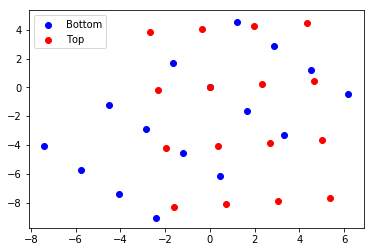

In [82]:
# Physics Parameters

a = 3.18 # Lattice constant of material (MoS2)
a= 3.314 # Lattice constant of material (TaS2)
# Bravais Lattice matrix which turns indices to real-space positions:
A = np.array([[1., np.cos(np.pi/3)  ],[0, np.sin(np.pi/3)]]  ) * a  #MoS2
A = np.array([[np.sqrt(3)/2, -.5],[np.sqrt(3)/2, .5]]) * a      #Ta S2
theta = 50# Angle of rotation in degrees  
theta_r= theta* np.pi / (180.)   # Convert to radians
R = np.array([ [ np.cos(theta_r), - np.sin(theta_r)],[np.sin(theta_r), np.cos(theta_r)]]) # Rotation Matrix

NN = 12**2

plot_atom_positions(generate_atom_positions(A,R,-2,2,-2,2))
print_atom_positions(generate_atom_positions(A,R,-2,2,-2,2),'atoms')
    









# Below here is junk



In [ ]:

                    
""" Deprecated
    for i in len(atoms):
        for j in len(atoms):
            for k in range(11):
                for l in range(11):
                    from_orb = index_to_orb_short[l]
                    to_orb   = index_to_orb_short[k]
                    
                    
                    
                    
                    
                    
                    Dx = atoms[j].position[0] - atoms[i].position[0]
                    Dy = atoms[j].position[1] - atoms[i].position[1]
                    Dz = atoms[j],position[2] - atoms[i].position[2]
                    #Dx,Dy = unit_cell_modulus(A,Dx,Dy)

                    orb_from = index_to_orb_short(k)
                    orb_to   = index_to_orb(l)
                    
                    
                    
                    TBH[i*11+k,j*11+l] = query_tbh_data(Dx,Dy,orb_from,orb_to)
    
    
"""
    

def build_interpolant_object(orb_from,orb_to,fidelity=2, x_count=20,y_count=20,z_count=20):
    """
    Queries the database to assemble a multidimensional array of coupling strengths
        to turn into a scipy interpolation object. 
        
        This might not be necessary. 
        
    NO STRAIN YET.
        
    str orb_from: which orbital we are considering from our 'home base' site
    str orb_to:   which orbital we are considering from our 'to' site
    fidelity: int 1, 2, 4, or 5, so long as it divides 20: the spacing of sampling to take
                    from the individual displacement runs (of which there are 400).
    x_count: how many x-values we had in our interpolation
    y_count: how many y-values we had in our interpolation
    z_count: how many z-values hwe had in our interpolation

    """
    
    X_extent = x_count / fidelity
    Y_extent = y_count / fidelity
    Z_extent = z_count / fidelity
    points=np.empty(shape=(X_extent,Y_extent,Z_extent))
    
    for i in X_extent:
        for j in Y_extent:
            for k in Z_extent:
                points[i,j,j]
    
    
                
            